<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/Miniproyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/vision-artificial.zip' >> /dev/null  # ACTUALIZAR: ruta al fichero comprimido


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/gdrive


In [2]:
from sklearn.preprocessing import LabelEncoder

# Especificar las rutas al directorio con las imágenes y al fichero con las etiquetas
data_path = '/content/'
imgtrain_dir = data_path + "train/images/"
csvtrain_file = data_path + "train.csv"

imgtest_dir = data_path + "test/images/"
csvtest_file = data_path + "test.csv"
# Leer el fichero CSV con las etiquetas

df = pd.read_csv(csvtrain_file, dtype = {"class": "category"})
dftest = pd.read_csv(csvtest_file, dtype = {"class": "category"})
# Codificar las etiquetas utilizando LabelEncoder
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

# Convertir las etiquetas codificadas en un vector one-hot
class_one_hot = pd.get_dummies(df['class_encoded'], prefix='class')

# Renombrar las columnas del vector one-hot
class_one_hot.columns = ['normal', 'benign', 'malignant']

# Concatenar el DataFrame original con las etiquetas one-hot
df = pd.concat([df[['image_filename']], class_one_hot], axis=1)

# Imprimir las primeras filas del DataFrame para verificar
print(df.head())


  image_filename  normal  benign  malignant
0  image_003.png    True   False      False
1  image_004.png    True   False      False
2  image_008.png    True   False      False
3  image_012.png    True   False      False
4  image_016.png    True   False      False


In [30]:
# Dividir el conjunto en entrenamiento, validación y test (80:10:10)
val_size = int(len(df) * 0.25)
test_size = int(len(df) * 0.2)

df = df.sample(frac=1).reset_index(drop=True)  # barajar el dataframe
dftest = df[:test_size]
dfval = df[test_size:test_size+val_size]
dftrain = df[test_size+val_size:]

print(f'Número de ejemplos del conjunto de entrenamiento: {dftrain.shape[0]}')
print(f'Número de ejemplos del conjunto de validación: {dfval.shape[0]}')
print(f'Número de ejemplos del conjunto de test: {dftest.shape[0]}')
dftrain = dftrain.reset_index(drop=True)
dfval = dfval.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

Número de ejemplos del conjunto de entrenamiento: 186
Número de ejemplos del conjunto de validación: 84
Número de ejemplos del conjunto de test: 67


In [49]:
dftrain
# Calcular el número de muestras para cada clase
num_normal = dftrain.loc[dftrain['normal'] == True].shape[0]
num_benign = dftrain.loc[dftrain['benign'] == True].shape[0]
num_malignant = dftrain.loc[dftrain['malignant'] == True].shape[0]

print("Número de muestras para la clase 'normal':", num_normal)
print("Número de muestras para la clase 'benign':", num_benign)
print("Número de muestras para la clase 'malignant':", num_malignant)


Número de muestras para la clase 'normal': 98
Número de muestras para la clase 'benign': 63
Número de muestras para la clase 'malignant': 25


In [73]:
import tensorflow as tf
from tensorflow.data import Dataset

# Dimensiones deseadas de la imagen
img_width, img_height = 224,224
n_channels = 3                # número de canales (RGB)
n_classes = 3                 # número de clases
x_col = 'image_filename'      # nombres de las columnas en el fichero CSV
y_col = ['normal', 'benign', 'malignant']  # lista de nombres de las columnas de las etiquetas

# Cargar y preprocesar imágenes
def load_and_preprocess_image(image_filename, label_one_hot):
    image_path = tf.strings.join([imgtrain_dir, image_filename])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=n_channels)
    # Redimensionar la imagen al tamaño deseado con relleno de ceros si es necesario
    image = tf.image.resize_with_pad(image, img_width, img_height)
    image = image / 255.0                               # normalización
    label = label_one_hot                                # Utilizar etiquetas codificadas como vector one-hot
    return image, label

# Crear conjunto de datos
def get_dataset(df):
    image_filenames = df[x_col].values
    labels = df[y_col].values
    dataset = tf.data.Dataset.from_tensor_slices((image_filenames, labels))
    dataset = dataset.map(load_and_preprocess_image)
    return dataset

# Crear los conjuntos de datos y preparar los lotes
batch_size = 64
train_dataset = get_dataset(dftrain).batch(batch_size)
val_dataset = get_dataset(dfval).batch(batch_size)
test_dataset = get_dataset(dftest).batch(batch_size)
print(f'Número de lotes del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Número de lotes del conjunto de validación: {len(val_dataset)}')
print(f'Número de lotes del conjunto de test: {len(test_dataset)}')

Número de lotes del conjunto de entrenamiento: 3
Número de lotes del conjunto de validación: 2
Número de lotes del conjunto de test: 2


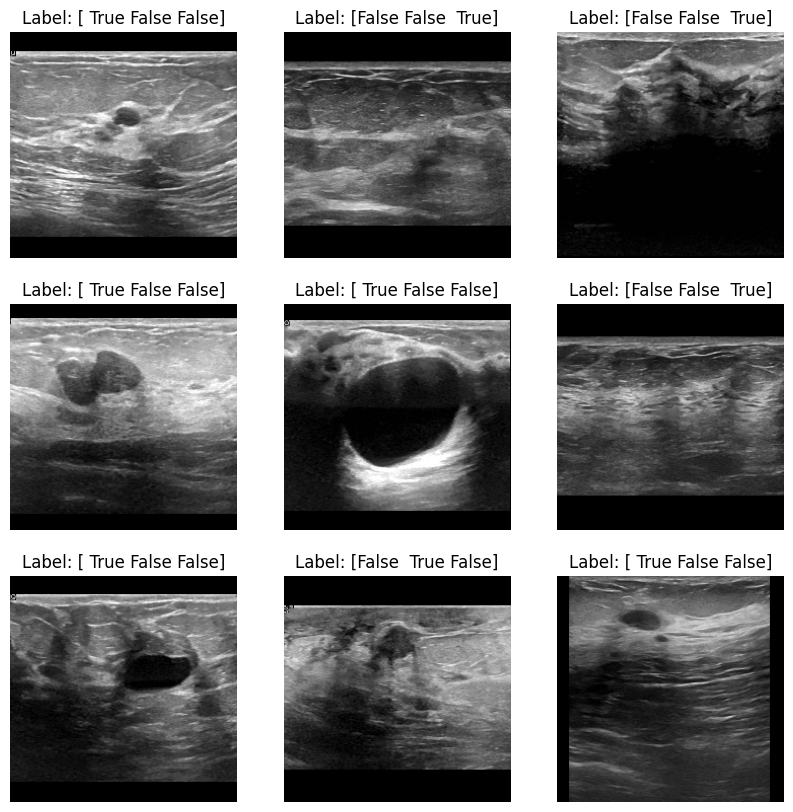

In [23]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes del conjunto de datos de entrenamiento
for images, labels in train_dataset.take(1):
    # Visualizar las primeras 9 imágenes del lote
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i].numpy()}')
        plt.axis('off')


In [78]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras import backend as K
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K

import tensorflow.keras.backend as K

def f1(y_true, y_pred):
    # Convertir las predicciones y verdaderos valores a tensores de TensorFlow
    y_pred_labels = K.round(y_pred)
    y_true_labels = K.round(y_true)

    # Calcular los valores verdaderos positivos, falsos positivos y falsos negativos para cada clase
    true_positives = K.sum(K.cast(y_true_labels * y_pred_labels, 'float'), axis=0)
    predicted_positives = K.sum(K.cast(y_pred_labels, 'float'), axis=0)
    possible_positives = K.sum(K.cast(y_true_labels, 'float'), axis=0)

    # Calcular la precisión y el recall para cada clase
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    # Calcular la métrica F1 para cada clase
    f1_per_class = 2 * (precision * recall) / (precision + recall + K.epsilon())

    # Calcular el peso de cada clase (número de ejemplos)
    num_examples_per_class = K.sum(y_true_labels, axis=0)
    class_weights = num_examples_per_class / K.sum(num_examples_per_class)

    # Calcular la métrica F1 promedio ponderada
    weighted_f1 = K.sum(class_weights * f1_per_class)

    return weighted_f1


def get_model(input_shape, num_classes):
    # Definir el modelo InceptionV3 pre-entrenado
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar las capas de la base del modelo
    base_model.trainable = False

    # Agregar capas adicionales de clasificación
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Capa de pooling global para reducir la dimensionalidad
    x = layers.Dense(1024, activation='relu')(x)  # Capa densa con activación ReLU
    predictions = layers.Dense(num_classes, activation='softmax')(x)  # Capa de salida con activación softmax

    # Combinar el modelo base con las capas adicionales
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Ejemplo de uso:
input_shape = (img_width, img_height, 3)  # Tamaño de entrada de las imágenes
num_classes = 3  # Número de clases en ImageNet
model = get_model(input_shape, num_classes)

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1])

# Resumen del modelo
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_1786 (Conv2D)        (None, 111, 111, 32)         864       ['input_20[0][0]']            
                                                                                                  
 batch_normalization_1786 (  (None, 111, 111, 32)         96        ['conv2d_1786[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1786 (Activatio  (None, 111, 111, 32)         0         ['batch_normalization_1

In [79]:
import numpy as np

# Entrenar el modelo con los datos preparados previamente
history = model.fit(train_dataset,
          epochs=15,   # número de epochs
          verbose=2,  # muestra información al finalizar cada epoch
          validation_data=val_dataset)

# Imprimir el error mínimo de entrenamiento y validación
train_trace = np.array(history.history['loss'])
print(f'\nError mínimo en entrenamiento: {min(train_trace):.6f}')

val_trace = np.array(history.history['val_loss'])
print(f'Error mínimo en validación: {min(val_trace):.6f}')

Epoch 1/15
3/3 - 8s - loss: 3.8095 - f1: 0.2796 - val_loss: 4.1018 - val_f1: 0.2240 - 8s/epoch - 3s/step
Epoch 2/15
3/3 - 1s - loss: 2.0002 - f1: 0.3926 - val_loss: 1.3078 - val_f1: 0.3824 - 1s/epoch - 477ms/step
Epoch 3/15
3/3 - 2s - loss: 0.8985 - f1: 0.5227 - val_loss: 1.2608 - val_f1: 0.2967 - 2s/epoch - 593ms/step
Epoch 4/15
3/3 - 2s - loss: 0.8527 - f1: 0.5100 - val_loss: 0.8818 - val_f1: 0.5467 - 2s/epoch - 558ms/step
Epoch 5/15
3/3 - 1s - loss: 0.5669 - f1: 0.6747 - val_loss: 0.9527 - val_f1: 0.4731 - 1s/epoch - 481ms/step
Epoch 6/15
3/3 - 1s - loss: 0.5175 - f1: 0.7010 - val_loss: 0.8212 - val_f1: 0.5973 - 1s/epoch - 476ms/step
Epoch 7/15
3/3 - 1s - loss: 0.4613 - f1: 0.8133 - val_loss: 0.8164 - val_f1: 0.6491 - 1s/epoch - 397ms/step
Epoch 8/15
3/3 - 1s - loss: 0.3760 - f1: 0.8873 - val_loss: 0.7859 - val_f1: 0.6616 - 1s/epoch - 480ms/step
Epoch 9/15
3/3 - 1s - loss: 0.3324 - f1: 0.8909 - val_loss: 0.8094 - val_f1: 0.6602 - 1s/epoch - 478ms/step
Epoch 10/15
3/3 - 2s - loss: 0.

In [80]:
test_loss, test_f1 = model.evaluate(test_dataset, verbose=2)
print("test_loss: %.4f, test_f1: %.4f" % (test_loss, test_f1))

2/2 - 0s - loss: 0.3898 - f1: 0.9000 - 463ms/epoch - 232ms/step
test_loss: 0.3898, test_f1: 0.9000


In [81]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np

# Directorio donde se encuentran las imágenes de prueba
test_images_dir = 'test/images/'

# Obtener la lista de nombres de archivos de las imágenes de prueba
test_filenames = os.listdir(test_images_dir)

# Crear un DataFrame para almacenar las predicciones
predictions_df = pd.DataFrame({'image_filename': test_filenames})

# Crear columnas para 'normal', 'benign' y 'malignant' con valores iniciales de 0
predictions_df['normal'] = 0
predictions_df['benign'] = 0
predictions_df['malignant'] = 0

# Iterar sobre cada imagen de prueba
for filename in test_filenames:
    # Cargar la imagen y preprocesarla
    img_path = os.path.join(test_images_dir, filename)
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión adicional para el lote

    # Realizar la predicción
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Obtener la clase predicha

    # Actualizar las columnas correspondientes según la predicción
    if predicted_class == 0:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'normal'] = 1
    elif predicted_class == 1:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'benign'] = 1
    elif predicted_class == 2:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'malignant'] = 1

# Ordenar el DataFrame por el nombre del archivo de imagen
predictions_df = predictions_df.sort_values(by='image_filename')

# Guardar el DataFrame en un archivo CSV
predictions_df.to_csv('test_predictions.csv', index=False)

# Imprimir las primeras filas del DataFrame para verificar
print(predictions_df.head())


1/1 [==============================] - 0s 24ms/step
    image_filename  normal  benign  malignant
64   image_005.png       1       0          0
53   image_006.png       1       0          0
112  image_007.png       0       1          0
40   image_009.png       0       1          0
21   image_010.png       1       0          0
